In [1]:
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam,SGD
from sklearn.metrics import jaccard_similarity_score as jss
from skimage.segmentation import find_boundaries as fb
from unet_modified import Unet
from loss_functions import val_loss_function

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [3]:
test_dataset=PlacesDataset(val_files,augment=10,transforms=True)

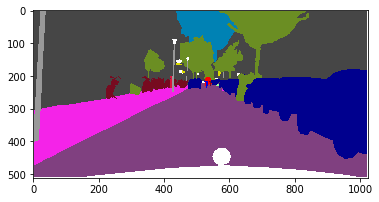

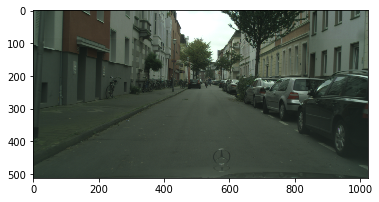

In [4]:
img,label,mask=test_dataset[140]
plt.imshow(test_dataset.decode_segmap(label.numpy()))
plt.show()
plt.imshow(img.numpy().transpose(1,2,0)[:,:,::-1])

In [5]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1)

In [6]:
unet=Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
unet=unet.to(device)

cuda


In [7]:
def test_IoU(input_image,target_image):
    with torch.no_grad():
        unet.eval()
        output_image=unet(input_image)
        loss=val_loss_function(output_image,target_image)
        return loss

In [8]:
checkpoint = torch.load('/scratch/ab8084/Unet/saved/model_refpad.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
batch = checkpoint['epoch']
tl = checkpoint['tl']
vl = checkpoint['vl']
unet.eval()
print("%--Loaded the model--%")

%--Loaded the model--%


In [9]:
loss_test=0
for j,inputs in enumerate(test_loader):
    input_image=(inputs[0]).to(device)
    target_image=(inputs[1]).to(device)
    loss_test+=test_IoU(input_image,target_image)
loss_test=loss_test/(j+1)
print (loss_test)

0.8353653259277344


In [ ]:
for j,inputs in enumerate(test_loader):
    input_image=(inputs[0]).to(device)
    target=(inputs[1]).to(device)
    with torch.no_grad():
        output_model=unet(input_image)
        n,c,h,w=output_model.size()
        n,ht,wt=target.size()

        if (h!=ht and w!=wt):
            output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)

        output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
        #print(output_model.size())
        output_model=output_model.cpu().numpy()
        #print(output_model.shape)
        predicted=np.argmax(output_model,axis=2)
    plt.imshow(train_dataset.decode_segmap(predicted), cmap='gray')
    plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
    plt.savefig('test_images/predicted/{}.png'.format(j+1))
    plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1])
    plt.savefig('test_images/actual/{}.png'.format(j+1))
    plt.imshow(train_dataset.decode_segmap(target.squeeze(0).cpu().numpy()), cmap='gray')
    plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
    plt.savefig('test_images/target/{}.png'.format(j+1))

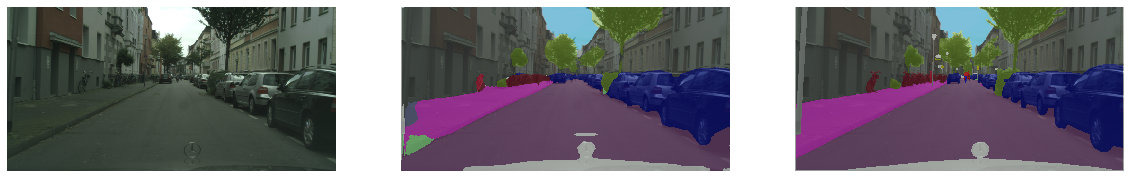

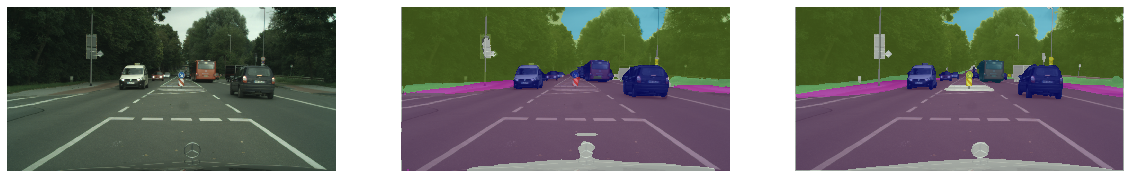

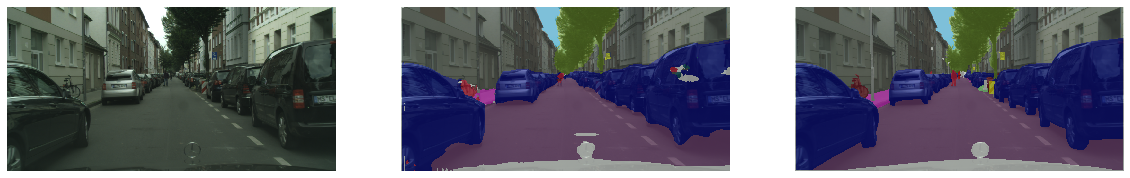

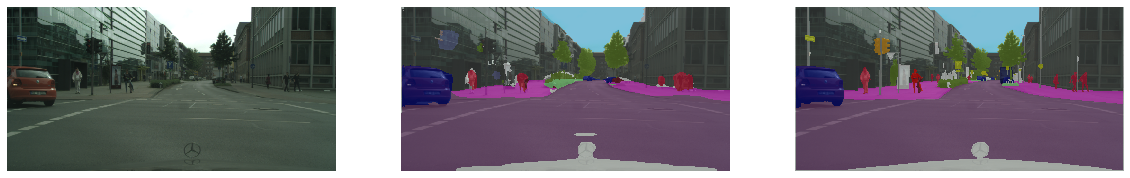

In [9]:
l=[140,160,170,200]
for i in range(4):
    input_image,target,mask=test_dataset[l[i]]
    input_image=(input_image.unsqueeze(0)).to(device)
    target=target.unsqueeze(0).to(device)
    with torch.no_grad():
        output_model=unet(input_image)
        n,c,h,w=output_model.size()
        n,ht,wt=target.size()

        if (h!=ht and w!=wt):
            output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)

        output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
    #print(output_model.size())
        output_model=output_model.cpu().numpy()
    #print(output_model.shape)
        predicted=np.argmax(output_model,axis=2)
        predicted[predicted==19]=255
    fig=plt.figure(figsize=(20,10))
    ax1=fig.add_subplot(1,3,2)
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    
    ax1.imshow(test_dataset.decode_segmap(predicted), cmap='gray')
    ax1.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
    ax1.axis('off')
    #ax1.show()
    ax2=fig.add_subplot(1,3,1)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1])
    ax2.axis('off')
    #ax2.show()
    ax3=fig.add_subplot(1,3,3)
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.imshow(test_dataset.decode_segmap(target.squeeze(0).cpu().numpy()), cmap='gray')
    ax3.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
    ax3.axis('off')
    #ax3.show()